In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

import importlib

import os
import crypto_object
from datetime import timedelta

In [25]:
crypto_object = importlib.reload(crypto_object)

def load_coins(dir_):
    """
    Function to take in a directory containing data
    and return a dictionary of `Coin` objects
    """
    
    # to store data
    coin_dict = {}
    
    for filename in os.listdir(dir_):
        
        # price data
        if filename.endswith("_price.csv"):
            
            # coin name
            coin_name = filename.split('_')[0]
            
            coin_dict[coin_name] = crypto_object.Coin(coin_name, dir_ + filename)
            
    return coin_dict

In [26]:
coins = load_coins('cryptocurrencypricehistory/')

# Backtester Architecture

Needs:
   * Position sizes
   * Ability to take in time-stamped, signals associated with particular weights/coins and create a new weighting matrix.



In [923]:
def Signal2Weights(coin_df, signal_df):
    """
    Returns
    -------
    
        weight_df : pandas.DataFrame
            index : dates, columns : crypto names
            containing relative weights
    """
    pass

class Backtest():

    def __init__(self, name, coin_dict, starting_value, start_date, end_date, weights_df):
        
        self.name = name
        self.coin_dict = coin_dict
        
        self.returns_df = self.get_returns_stream(coin_dict)
        
        # initialize weight dict
        self.weight_dict = {k : 0 for k in self.coin_dict.keys()}
        self.start_date = start_date
        self.end_date = end_date
        self.weights_df = weights_df
        self.starting_value = starting_value
        self.backtest_results = None
        
        
    def normalize_weights(self, weight_dict, t):
        
        # correct for coins that havent started yet
        clean_wts = {k : (weight_dict[k] if self.coin_dict[k].start.date() < t else 0) for k in weight_dict.keys()}
        ws = np.nansum(np.abs(list(clean_wts.values())))
        
        return {k : clean_wts[k] / ws for k in clean_wts.keys()}
    
    def get_returns_stream(self, coin_dict):
        
        for i, k in enumerate(coin_dict.keys()):
            # first initialize df
            if i == 0:
                df = coin_dict[k].full_data.loc[:, ['Date', 'Pct Returns']]
                df.rename(columns={'Date' : 'Date', 'Pct Returns' : k}, inplace=True)
            else:
                df = df.merge(coin_dict[k].full_data.loc[:, ['Date', 'Pct Returns']], on='Date', how='outer')
                # rename Pct Returns Column
                df.rename(columns={'Pct Returns' : k}, inplace=True)
                
        return df.set_index('Date')
    
    
    def run_backtest(self):
        
        t = self.start_date
        
        # number of days in backtest
        N_days = (self.end_date - self.start_date).days
        
        # get first holdings
        starting_weights = self.normalize_weights(self.weights_df.iloc[-1, :].to_dict(), t)
        holdings = {k : v * self.starting_value for k,v in starting_weights.items()}
        performance_value = np.empty((N_days, ))
        performance_value[0] = 0
        
        portfolio_value = np.empty((N_days, ))
        portfolio_value[0] = self.starting_value
        
        for i in np.arange(1, N_days):
            
            t = t + timedelta(days=1)
            
            # returns on day
            try:
                returns_t_dict = self.returns_df.loc[pd.Timestamp(t), ].to_dict()
            except KeyError:
                print('Invalid Day for backtest')
            
            # weights on day
            try:
                weights_t_dict = self.normalize_weights(self.weights_df.loc[pd.Timestamp(t), ].to_dict(), t)
            except KeyError:
                print('Invalid Day for backtest')
                
                
            accrued_holdings = {k: v * (1 + returns_t_dict[k]) for k, v in holdings.items()}
            long_holdings_diff = np.nansum([v - holdings[k] for k, v in accrued_holdings.items() if v >= 0])
            short_holdings_diff = np.nansum([holdings[k] - v for k, v in accrued_holdings.items() if v < 0])
            performance_value[i] = (long_holdings_diff - short_holdings_diff) + performance_value[i-1]
            
            # new weightings
            port_value = np.nansum(np.abs(list(accrued_holdings.values())))
            portfolio_value[i] = port_value
            holdings = {k : v * port_value for k,v in weights_t_dict.items()}
                
        self.backtest_results = performance_value
        
        
    def plot_backtest(self, port=False):
        f, ax = plt.subplots(1,1, figsize=(12,8))
        ax.plot(self.weights_df.index[1:], self.backtest_results, label='Performance Value')
            
        ax.axhline(0, ls='--', color='red')
        ax.set_title('Backtest: ' + self.name)
        ax.set_ylabel('Value')
        ax.set_xlabel('Time')
        ax.legend()

In [924]:
d1 = datetime.date(2016, 4, 1)
d2 = datetime.date(2018, 1, 1)
days = pd.date_range(d1, d2)
weight_df = pd.DataFrame(np.random.randint(low=-5, high=10, size=(len(days), len(coins))), index=days, columns=coins.keys())
weight_df.head()

,bitcoin,bitconnect,dash,ethereum,iota,litecoin,monero,nem,neo,numeraire,omisego,qtum,ripple,stratis,waves
2016-04-01,4,6,1,1,2,0,9,1,2,5,9,8,3,-5,7
2016-04-02,9,-2,-3,8,7,-4,0,-5,7,-4,-4,0,6,-1,-5
2016-04-03,-2,7,-5,8,-3,6,-2,8,-4,-2,-5,7,-5,-4,1
2016-04-04,3,1,1,3,1,8,8,0,3,8,4,3,7,7,7
2016-04-05,8,4,7,-4,1,8,1,0,-1,5,9,3,-4,6,0


In [925]:
a = Backtest('a', coins, 100, d1, d2, weight_df)
a.run_backtest()

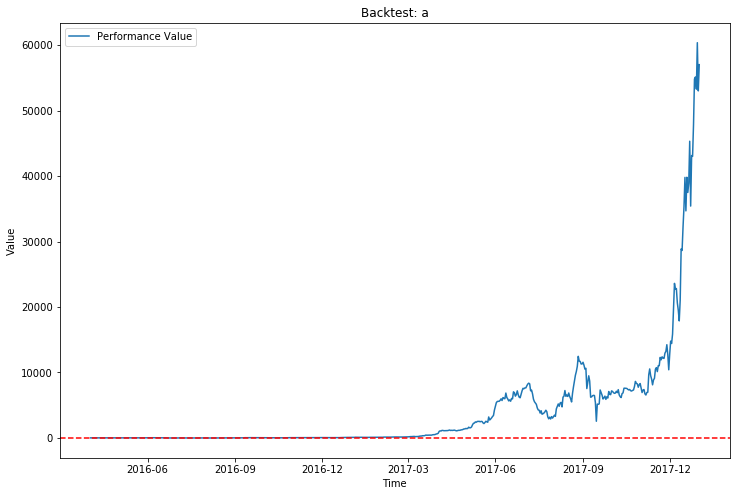

In [926]:
a.plot_backtest()

In [927]:
a.returns_df

,bitcoin,bitconnect,dash,ethereum,iota,litecoin,monero,nem,neo,numeraire,omisego,qtum,ripple,stratis,waves
Date,,,,,,,,,,,,,,,
2018-02-20,0.015893,-0.108861,-0.059954,-0.051384,-0.086124,0.043890,-0.038200,-0.084767,-0.066269,-0.023751,0.040136,-0.047459,-0.043860,-0.082412,-0.008642
2018-02-19,0.063828,0.067568,0.057234,0.021593,0.055556,0.033930,0.054545,-0.002161,0.079212,0.195301,0.061825,0.045455,0.017857,0.074514,0.074271
2018-02-18,-0.050474,-0.141531,-0.071251,-0.051534,-0.100000,-0.059834,-0.078454,-0.114335,-0.068519,-0.121290,-0.089120,-0.069130,-0.066667,-0.051230,-0.038265
2018-02-17,0.085871,0.043584,0.061958,0.031677,0.047619,-0.002825,0.098455,0.052722,0.061312,0.094118,0.006604,0.016354,0.052632,0.020921,-0.007595
2018-02-16,0.006640,0.022277,-0.007104,0.007716,-0.014085,0.020805,-0.022325,0.013410,0.045097,-0.041065,0.089982,-0.001210,-0.008696,0.002096,-0.021066
2018-02-15,0.070753,0.083110,0.036643,0.014531,0.049261,0.056571,0.096111,-0.015168,0.006285,0.002715,0.064496,0.015668,0.008772,0.019231,0.257009
2018-02-14,0.104244,0.231023,0.140242,0.092634,0.121547,0.337261,0.178832,0.069055,0.102096,0.095144,0.205543,0.081036,0.106796,0.177358,0.146429
2018-02-13,-0.036773,0.006645,-0.040431,-0.026994,-0.032086,-0.012502,-0.052026,-0.044288,-0.018366,-0.081893,0.011682,-0.000664,-0.046296,0.006329,-0.020979
2018-02-12,0.097983,0.337778,0.069894,0.066347,0.100000,0.084435,0.078783,0.055338,0.095261,0.200437,0.082631,0.096434,0.080000,0.130186,0.049541


In [928]:
coins['neo'].start

Timestamp('2016-09-09 00:00:00')

In [929]:
a.returns_df

,bitcoin,bitconnect,dash,ethereum,iota,litecoin,monero,nem,neo,numeraire,omisego,qtum,ripple,stratis,waves
Date,,,,,,,,,,,,,,,
2018-02-20,0.015893,-0.108861,-0.059954,-0.051384,-0.086124,0.043890,-0.038200,-0.084767,-0.066269,-0.023751,0.040136,-0.047459,-0.043860,-0.082412,-0.008642
2018-02-19,0.063828,0.067568,0.057234,0.021593,0.055556,0.033930,0.054545,-0.002161,0.079212,0.195301,0.061825,0.045455,0.017857,0.074514,0.074271
2018-02-18,-0.050474,-0.141531,-0.071251,-0.051534,-0.100000,-0.059834,-0.078454,-0.114335,-0.068519,-0.121290,-0.089120,-0.069130,-0.066667,-0.051230,-0.038265
2018-02-17,0.085871,0.043584,0.061958,0.031677,0.047619,-0.002825,0.098455,0.052722,0.061312,0.094118,0.006604,0.016354,0.052632,0.020921,-0.007595
2018-02-16,0.006640,0.022277,-0.007104,0.007716,-0.014085,0.020805,-0.022325,0.013410,0.045097,-0.041065,0.089982,-0.001210,-0.008696,0.002096,-0.021066
2018-02-15,0.070753,0.083110,0.036643,0.014531,0.049261,0.056571,0.096111,-0.015168,0.006285,0.002715,0.064496,0.015668,0.008772,0.019231,0.257009
2018-02-14,0.104244,0.231023,0.140242,0.092634,0.121547,0.337261,0.178832,0.069055,0.102096,0.095144,0.205543,0.081036,0.106796,0.177358,0.146429
2018-02-13,-0.036773,0.006645,-0.040431,-0.026994,-0.032086,-0.012502,-0.052026,-0.044288,-0.018366,-0.081893,0.011682,-0.000664,-0.046296,0.006329,-0.020979
2018-02-12,0.097983,0.337778,0.069894,0.066347,0.100000,0.084435,0.078783,0.055338,0.095261,0.200437,0.082631,0.096434,0.080000,0.130186,0.049541


In [936]:
def MOMENTUM(coin_df, signal_df, d1, d2):
    """
    Returns
    -------
    
        weight_df : pandas.DataFrame
            index : dates, columns : crypto names
            containing relative weights
            
            
        TRADE SIGNAL : If previous return is positive, long it. If previous return is negative, short it. 
    """ 
    
    days = pd.date_range(d1, d2)
    
    trade_df = np.ones((len(days), len(coin_df)))
    
    for i in np.arange(1, len(days)):
        for j, coin in enumerate(coin_df.keys()):
        
            prev_ret = signal_df.loc[days[i-1], coin]
            if prev_ret < 0:
                trade_df[i, j] = -1
            else:
                trade_df[i, j] = 1
                
    return pd.DataFrame(trade_df, index=days, columns=coin_df.keys())

def MEANREVERSION(coin_df, signal_df, d1, d2):
    """
    Returns
    -------
    
        weight_df : pandas.DataFrame
            index : dates, columns : crypto names
            containing relative weights
            
            
        TRADE SIGNAL : If previous 5D return is positive, short it. If previous 5D return is negative, long it. 
    """ 
    
    days = pd.date_range(d1, d2)
    
    trade_df = np.ones((len(days), len(coin_df)))
    
    for i in np.arange(5, len(days)):
        for j, coin in enumerate(coin_df.keys()):
            prev_rets = np.nanmean(signal_df.loc[days[i-1]:days[i-5], coin])
            if prev_rets < 0:
                trade_df[i, j] = 1
            else:
                trade_df[i, j] = -1
                
    return pd.DataFrame(trade_df, index=days, columns=coin_df.keys())

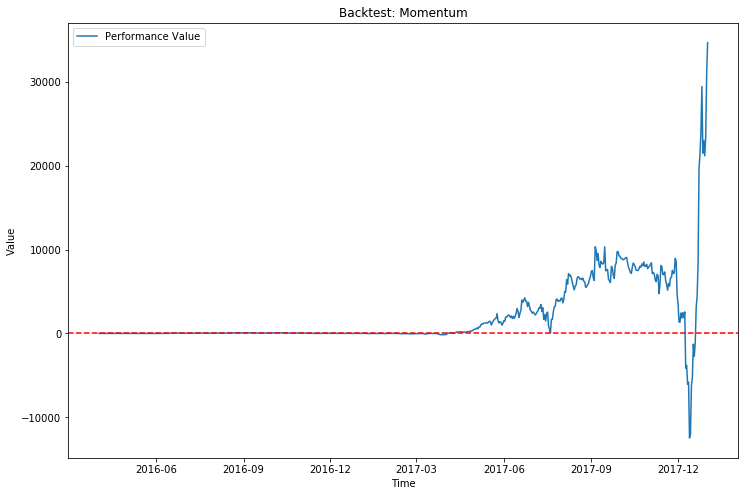

In [937]:
momentum_weights = MOMENTUM(coins, a.returns_df, d1, d2)
momentum_backtest = Backtest('Momentum', coins, 100, d1, d2, momentum_weights)
momentum_backtest.run_backtest()
momentum_backtest.plot_backtest()

//anaconda/envs/cs109env/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: Mean of empty slice


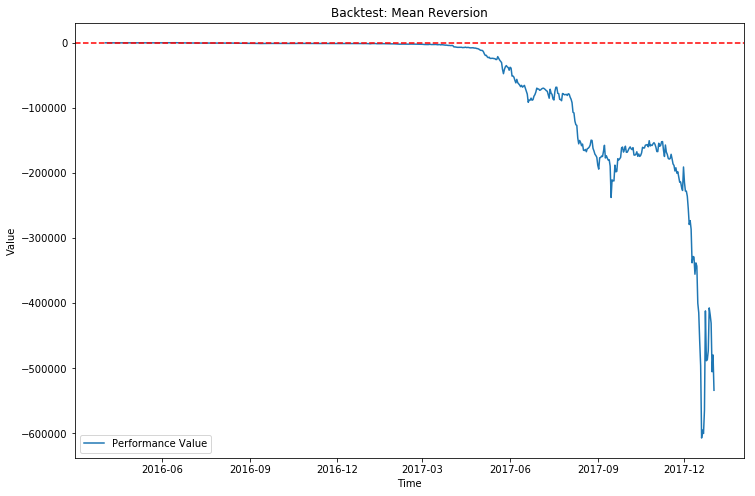

In [938]:
mean_rev_weights = MEANREVERSION(coins, a.returns_df, d1, d2)
mean_rev_backtest = Backtest('Mean Reversion', coins, 1000, d1, d2, mean_rev_weights)
mean_rev_backtest.run_backtest()
mean_rev_backtest.plot_backtest()

In [880]:
mean_rev_backtest.backtest_results - momentum_backtest.backtest_results

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [921]:
momentum_backtest.weights_df

,bitcoin,bitconnect,dash,ethereum,iota,litecoin,monero,nem,neo,numeraire,omisego,qtum,ripple,stratis,waves
2016-04-01,-5,-1,2,6,4,-4,7,9,1,7,-3,3,-3,7,-4
2016-04-02,7,7,-5,6,9,-1,9,6,6,-2,-4,-3,3,1,-2
2016-04-03,1,-4,1,5,3,8,4,1,3,7,7,1,8,0,8
2016-04-04,8,-1,0,8,0,1,6,9,1,2,-5,-2,-4,9,-4
2016-04-05,7,1,-3,0,2,2,0,3,3,-4,7,7,-3,-4,-2
2016-04-06,4,1,1,-4,6,6,6,-1,6,-1,-2,-2,-4,9,-2
2016-04-07,4,-5,7,1,-3,-2,0,-1,7,2,7,1,6,2,4
2016-04-08,-3,6,1,-2,0,2,5,4,-5,-4,-1,3,-1,-3,-1
2016-04-09,7,-2,0,1,-2,-2,7,9,3,-5,1,1,6,6,7
2016-04-10,6,9,2,3,-3,-3,-4,7,-5,-1,4,1,6,4,-3


In [922]:
momentum_weights

,bitcoin,bitconnect,dash,ethereum,iota,litecoin,monero,nem,neo,numeraire,omisego,qtum,ripple,stratis,waves
2016-04-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-04-02,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-04-03,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-04-04,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2016-04-05,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
2016-04-06,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
2016-04-07,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
2016-04-08,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
2016-04-09,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
2016-04-10,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0


State hypothesis, conclusions from hypothesis.